In [40]:
from sklearn.preprocessing import RobustScaler, StandardScaler
import pandas_profiling
from statsmodels.robust.scale import huber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import re
import locale
import geopandas
plt.style.use('seaborn')
%matplotlib inline
import seaborn as sns
sns.set_style('dark')  

pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)


df_final_pob=pd.read_parquet('../data/main_processed/df_final_pob.parquet')

df_indicadores_pob=pd.read_parquet('../data/main_processed/df_indicadores_pob.parquet')

df_indicadores_pob_pivot=pd.read_parquet('../data/main_processed/df_indicadores_pob_pivot.parquet')

df_final_pob_melt=pd.read_parquet('../data/main_processed/df_final_pob_melt.parquet')

df_final_pob_melt_PC=pd.read_parquet('../data/main_processed/df_final_pob_melt_PC.parquet')

CCAA_CO = pd.read_parquet('../data/main_processed/CCAA_CO.parquet')
MUNI_CO = pd.read_parquet('../data/main_processed/MUNI_CO.parquet')
PROV_CO = pd.read_parquet('../data/main_processed/PROV_CO.parquet')

df_final_pob_dropdown=pd.read_parquet('../data/main_processed/df_final_pob_dropdown.parquet')

df_final_pob_dropdown_c=pd.read_parquet('../data/main_processed/df_final_pob_dropdown_c.parquet')

df_final_pob_poblaciontext=pd.read_parquet('../data/main_processed/df_final_pob_poblaciontext.parquet')

In [2]:
CCAA_types='Andalucía'
municipio_types= 'Sevilla'
cohorte='1.000-2.000'
partida_de_coste_types='Abastecimiento de agua potable'

In [20]:
df_final_pob.columns

Index(['CCAA', 'Provincia', 'Tipo Ente Principal', 'Nombre Ente Principal',
       'Código Ente Principal', 'Abastecimiento de agua potable',
       'Abastos, mercados, lonjas ', 'Acceso a los núcleos de población',
       'Actividades funerarias', 'Alcantarillado', 'Alumbrado público',
       'Biblioteca pública', 'Cementerio', 'Comercio ambulante',
       'Conservación y rehabilitación de la edificación',
       'Conservación, mantenimiento y vigilancia de los edificios destinados a educación',
       'Cooperar con las Administraciones educativas en la obtención de solares',
       'Equipamientos culturales',
       'Evacuación y tratamiento de aguas residuales', 'Ferias ',
       'Información y promoción de la actividad turística de interés y ámbito local',
       'Infraestructura viaria y otros equipamientos de titularidad de la entidad local',
       'Instalaciones de ocupación del tiempo libre',
       'Instalaciones deportivas', 'Instalaciones deportivas de uso público',
       

In [46]:
top=df_final_pob[['CCAA', 'Provincia', 'Tipo Ente Principal', 'Nombre Ente Principal',
       'Código Ente Principal', 'Población 2018', 'TOTAL',
       'PC_TOTAL', 'cohorte_pob', 'codigo_geo','PC_Transporte colectivo urbano de viajeros']].sort_values(by='PC_Transporte colectivo urbano de viajeros',ascending=False)

top.loc[top['Población 2018']<50000].head(10)

,CCAA,Provincia,Tipo Ente Principal,Nombre Ente Principal,Código Ente Principal,Población 2018,TOTAL,PC_TOTAL,cohorte_pob,codigo_geo,PC_Transporte colectivo urbano de viajeros
4713,Comunitat Valenciana,Valencia / València,Ayuntamiento,Cortes de Pallás,17-46-099-AA-000,818.0,2298901.04,2810.392469,0-1.000,46099,182.532066
1080,Aragón,Zaragoza,Ayuntamiento,Terrer,02-50-253-AA-000,485.0,151877.37,313.149216,0-1.000,50253,148.143505
739,Aragón,Huesca,Ayuntamiento,Montanuy,02-22-157-AA-000,215.0,948738.30,4412.736279,0-1.000,22157,84.242372
4047,Galicia,Ourense,Ayuntamiento,Chandrexa de Queixa,11-32-029-AA-000,466.0,410719.13,881.371524,0-1.000,32029,69.012876
4373,La Rioja,"Rioja, La",Ayuntamiento,Villamediana de Iregua,16-26-168-AA-000,7973.0,2807779.30,352.160956,5.000-10.000,26168,58.369590
3487,Cataluña,Tarragona,Ayuntamiento,Mont-roig del Camp,09-43-092-AA-000,11809.0,17218001.91,1458.040639,10.000-20.000,43092,51.692594
744,Aragón,Huesca,Ayuntamiento,Panticosa,02-22-170-AA-000,786.0,1325951.00,1686.960560,0-1.000,22170,49.239186
2071,Castilla y León,Salamanca,Ayuntamiento,Carrascal de Barregas,07-37-087-AA-000,1188.0,539318.04,453.971414,1.000-2.000,37087,48.031077
2884,Cataluña,Barcelona,Ayuntamiento,Lliçà d'Amunt,09-08-107-AA-000,15111.0,14262110.35,943.823066,10.000-20.000,8107,44.032108
1149,Principado de Asturias,Asturias,Ayuntamiento,Mieres (Asturias),03-33-037-AA-000,38428.0,21444849.51,558.052709,20.000-50.000,33037,39.976665


In [21]:
def remove_outlier(df , col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_clean = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]
    return df_clean

In [37]:
media=remove_outlier(df_final_pob , 'PC_TOTAL')
media=media.loc[(media['PC_TOTAL']>1)]
media['PC_TOTAL'].describe()

count    4590.000000
mean      498.593307
std       274.651685
min         8.587786
25%       290.163578
50%       459.274292
75%       658.355898
max      1319.990990
Name: PC_TOTAL, dtype: float64

In [38]:
df_final_pob['PC_TOTAL'].describe()


count    4869.000000
mean      573.644779
std       458.223443
min         0.000000
25%       299.443169
50%       477.853185
75%       707.883274
max      5323.980060
Name: PC_TOTAL, dtype: float64

In [39]:

# print(media.shape)
pc='PC_TOTAL'
pivot=media.pivot_table(index=['cohorte_pob'],values=[pc],aggfunc=np.mean).reset_index()
pivot

,cohorte_pob,PC_TOTAL
0,0-1.000,468.166118
1,1.000-2.000,481.373380
2,2.000-5.000,484.612568
3,5.000-10.000,536.498690
4,10.000-20.000,578.294082
5,20.000-50.000,612.877528
6,50.000-100.000,676.218481
7,100.000-200.000,753.632462
8,200.000-500.000,788.807067
9,más de 500.000,941.120950


In [46]:
df_table = {'Tamaño municipio': ['Hasta 1.000 habitantes','Entre 1.000 y 2.000 habitantes','Entre 2.000 y 5.000 habitantes',
                                'Entre 5.000 y 10.000 habitantes','Entre 10.000 y 20.000 habitantes','Entre 20.000 y 50.000 habitantes',
                                'Entre 50.000 y 100.000 habitantes ','Entre 100.000 y 200.000 habitantes ','Entre 200.000 y 500.000 habitantes',
                                'Más de 500.000 habitantes'],'Coste efectivo medio por habitante':[696,552,496,479,514,528,591,705,682,864] }
df_table = pd.DataFrame(data=df_table)



df_table

,Tamaño municipio,Coste efectivo medio por habitante
0,Hasta 1.000 habitantes,696
1,Entre 1.000 y 2.000 habitantes,552
2,Entre 2.000 y 5.000 habitantes,496
3,Entre 5.000 y 10.000 habitantes,479
4,Entre 10.000 y 20.000 habitantes,514
5,Entre 20.000 y 50.000 habitantes,528
6,Entre 50.000 y 100.000 habitantes,591
7,Entre 100.000 y 200.000 habitantes,705
8,Entre 200.000 y 500.000 habitantes,682
9,Más de 500.000 habitantes,864


<AxesSubplot:xlabel='Tamaño municipio', ylabel='Coste efectivo medio por habitante'>

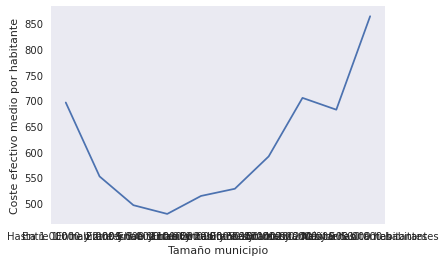

In [48]:
sns.lineplot(data=df_table, x='Tamaño municipio', y="Coste efectivo medio por habitante",  palette='bright')


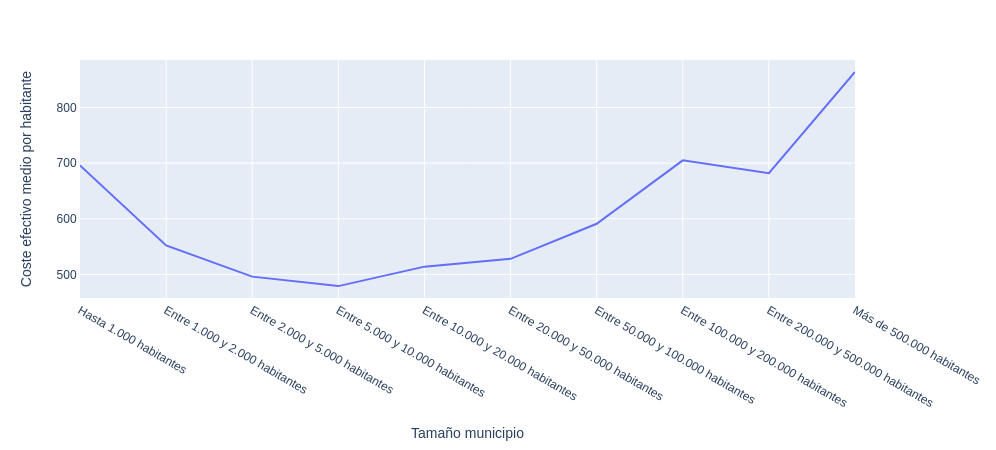

In [49]:
px.line(df_table,  x='Tamaño municipio', y="Coste efectivo medio por habitante")

In [43]:
10750/28

383.92857142857144

In [31]:
pd.set_option('display.max_rows', 65)

df_indicadores_pob_pivot.loc[df_indicadores_pob_pivot['Nombre Ente Principal']=='Oropesa del Mar/Orpesa']

,Nombre Ente Principal,Descripción,Unidades físicas de referencia,Nº unidades
246075,Oropesa del Mar/Orpesa,Abastecimiento de agua potable,Longitud de la red: metros lineales,156000.00
246076,Oropesa del Mar/Orpesa,Abastecimiento de agua potable,Nº viviendas conectadas y no conectadas,20876.00
246077,Oropesa del Mar/Orpesa,"Abastos, mercados, lonjas",Nº puestos,175.00
246078,Oropesa del Mar/Orpesa,"Abastos, mercados, lonjas",Superficie total en metros cuadrados,9600.00
246079,Oropesa del Mar/Orpesa,Acceso a los núcleos de población,Puntos kilométricos: P.K correspondientes al i...,990.70
246082,Oropesa del Mar/Orpesa,Alcantarillado,Longitud del tramo: metros lineales.,104125.00
246083,Oropesa del Mar/Orpesa,Alcantarillado,Nº viviendas con servicio,20876.00
246084,Oropesa del Mar/Orpesa,Alumbrado público,Nº puntos de luz,9950.00
246085,Oropesa del Mar/Orpesa,Alumbrado público,Potencia instalada,1150.00
246086,Oropesa del Mar/Orpesa,Alumbrado público,Superficie iluminada: metros lineales,1410.00


In [26]:
1+3+1+3+2+3+3+7+33+3+2+1+1+6

69

In [32]:
8830/43

205.34883720930233